Sure, let's break it down:
The step Function:

This function simulates one step in the stock trading environment based on the action chosen by the agent.

Parameters:

    action: The action chosen by the agent. It can be:
        0: Hold (i.e., do nothing)
        1: Buy
        2: Sell

Inside the function:

    current_row = self.data.iloc[self.index]: Get the current row of the stock data based on the current index.

    next_row = self.data.iloc[self.index + 1]: Get the next row, which represents the stock data for the next day.

    reward = 0: Initialize the reward to 0.

    If action is 1 (Buy), then:
        reward = (next_row['Close'] - current_row['Open']): The reward is calculated as the difference between the closing price of the next day and the opening price of the current day. This simulates buying the stock at the opening price of the current day and selling it at the closing price of the next day.

    Else if action is 2 (Sell), then:
        reward = (current_row['Open'] - next_row['Close']): The reward is calculated as the difference between the opening price of the current day and the closing price of the next day. This simulates selling the stock at the opening price of the current day and buying it back at the closing price of the next day.

    self.total_reward += reward: Add the reward for this step to the cumulative total reward.

    self.index += 1: Move to the next day in the stock data.

    If the current index exceeds the length of the data (reaches the last row), mark self.done as True. This indicates that the episode has ended.

    Finally, return the values:
        next_row.values: The stock data for the next day.
        reward: Reward obtained in this step.
        self.done: A boolean indicating if the episode is done.
        {}: An empty dictionary, typically used in other environments to provide additional info. Here, it's just a placeholder.

The action_space Function:

This function returns the number of possible actions.

    It simply returns 3 since there are three possible actions: 0 (Hold), 1 (Buy), and 2 (Sell).

The observation_space Function:

This function returns the number of features (or attributes) in the stock data.

    It uses len(self.data.columns) to count the number of columns in the stock data DataFrame. This represents the number of features the agent observes at each step, such as 'Open', 'Close', 'Volume', 'Return', etc.

In summary, this portion of the code defines the dynamics of the stock trading environment. It specifies how the environment behaves based on agent actions, how rewards are computed, and what observations the agent sees.

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random

# Fetch Dow Jones 30 stocks
tickers = ["AAPL"]  # Add all 30 here

def fetch_data(tickers):
    data = {}
    for ticker in tickers:
        stock_data = yf.download(ticker, start="2021-01-01", end="2023-10-01", progress=False)
        stock_data['Return'] = stock_data['Close'].pct_change()
        data[ticker] = stock_data.dropna()
    return data

data = fetch_data(tickers)
df = data

# Define the environment
class StockTradingEnv:
    def __init__(self, data):
        self.data = data
        self.index = 0
        self.done = False
        self.total_reward = 0
        self.initial_balance = 10000.0
        self.balance = self.initial_balance

    def reset(self):
        self.index = 0
        self.done = False
        self.total_reward = 0
        self.balance = self.initial_balance
        return self.data.iloc[self.index].values

    def step(self, action):
        # 0->Hold, 1->Buy, 2->Sell
        current_row = self.data.iloc[self.index]
        next_row = self.data.iloc[self.index + 1]
        reward = 0
        if action == 1:  # Buy
            reward = (next_row['Close'] - current_row['Open'])
        elif action == 2:  # Sell
            reward = (current_row['Open'] - next_row['Close'])

        self.total_reward += reward
        self.index += 1

        if self.index >= len(self.data) - 1:
            self.done = True

        return next_row.values, reward, self.done, {}

    def action_space(self):
        return 3

    def observation_space(self):
        return len(self.data.columns)

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, self.action_size)
        )
        self.optimizer = optim.Adam(model.parameters(), lr=self.learning_rate)
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))


    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        state_tensor = torch.FloatTensor(state).float()  # Ensure it's a FloatTensor
        act_values = self.model(state_tensor)
        return torch.argmax(act_values).item()

    def replay(self, batch_size):
      minibatch = random.sample(self.memory, batch_size)
      criterion = nn.MSELoss()  # Define the loss criterion
      for state, action, reward, next_state, done in minibatch:
          state_tensor = torch.FloatTensor(state).float()  # Ensure it's a FloatTensor
          next_state_tensor = torch.FloatTensor(next_state).float()  # Ensure it's a FloatTensor

          if not done:
              target = reward + self.gamma * torch.max(self.model(next_state_tensor)).item()
          else:
              target = reward
          target_tensor = torch.tensor([target], dtype=torch.float32)

          current_value = self.model(state_tensor).squeeze()[action].unsqueeze(0)  # Adjusted for the correct shape
          loss = criterion(current_value, target_tensor)

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()
      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay


    def load(self, name):
          self.model.load_state_dict(torch.load(name))


    def save(self, name):
        torch.save(self.model.state_dict(), name)

# Training loop
env = StockTradingEnv(df["AAPL"])
#env = StockTradingEnv(df)
state_size = env.observation_space()
action_size = env.action_space()
agent = DQNAgent(state_size, action_size)

EPISODES = 200
for e in range(EPISODES):
    state = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"episode: {e+1}/{EPISODES}, reward: {env.total_reward}, epsilon: {agent.epsilon:.2}")
    if len(agent.memory) > 32:
        agent.replay(32)

# Save the model
agent.save("dqn_model.pth")


episode: 1/200, reward: 153.0898666381836, epsilon: 1.0
episode: 2/200, reward: -128.18988800048828, epsilon: 0.99
episode: 3/200, reward: 136.42009735107422, epsilon: 0.99
episode: 4/200, reward: 37.75993347167969, epsilon: 0.99
episode: 5/200, reward: -2.2501449584960938, epsilon: 0.98
episode: 6/200, reward: 13.489768981933594, epsilon: 0.98
episode: 7/200, reward: 72.99014282226562, epsilon: 0.97
episode: 8/200, reward: -37.59986877441406, epsilon: 0.97
episode: 9/200, reward: 9.359794616699219, epsilon: 0.96
episode: 10/200, reward: 26.779891967773438, epsilon: 0.96
episode: 11/200, reward: 51.819976806640625, epsilon: 0.95
episode: 12/200, reward: -104.49002075195312, epsilon: 0.95
episode: 13/200, reward: -112.66998291015625, epsilon: 0.94
episode: 14/200, reward: 37.159881591796875, epsilon: 0.94
episode: 15/200, reward: -230.79998016357422, epsilon: 0.93
episode: 16/200, reward: 54.48999786376953, epsilon: 0.93
episode: 17/200, reward: 96.93977355957031, epsilon: 0.92
episode:

In [3]:
import pandas as pd

# ... [Your previous code]

# Collecting results in a list of dictionaries
results = []

for e in range(EPISODES):
    state = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"episode: {e+1}/{EPISODES}, reward: {env.total_reward}, epsilon: {agent.epsilon:.2}")
            results.append({
                "Episode": e+1,
                "Reward": env.total_reward,
                "Epsilon": agent.epsilon
            })
    if len(agent.memory) > 32:
        agent.replay(32)

# Convert the results to a pandas DataFrame and save to Excel
results_df = pd.DataFrame(results)
results_df.to_excel("agent_results_2.xlsx", index=False)


episode: 1/200, reward: 134.24996185302734, epsilon: 0.13
episode: 2/200, reward: -37.020042419433594, epsilon: 0.13
episode: 3/200, reward: 2.5499954223632812, epsilon: 0.13
episode: 4/200, reward: -19.610008239746094, epsilon: 0.13
episode: 5/200, reward: 117.4496078491211, epsilon: 0.13
episode: 6/200, reward: 22.419776916503906, epsilon: 0.13
episode: 7/200, reward: -4.149986267089844, epsilon: 0.13
episode: 8/200, reward: -32.650047302246094, epsilon: 0.13
episode: 9/200, reward: -126.91976928710938, epsilon: 0.13
episode: 10/200, reward: 14.029945373535156, epsilon: 0.13
episode: 11/200, reward: -32.63002014160156, epsilon: 0.13
episode: 12/200, reward: 12.159927368164062, epsilon: 0.13
episode: 13/200, reward: -0.4699859619140625, epsilon: 0.13
episode: 14/200, reward: 130.20974731445312, epsilon: 0.13
episode: 15/200, reward: 105.33979797363281, epsilon: 0.13
episode: 16/200, reward: -132.63976287841797, epsilon: 0.12
episode: 17/200, reward: -147.13987731933594, epsilon: 0.12


In [6]:
import pandas as pd
df = pd.read_excel('agent_results_2.xlsx')
df.head()

,Episode,Reward,Epsilon
0,1,134.249962,0.134658
1,2,-37.020042,0.133985
2,3,2.549995,0.133315
3,4,-19.610008,0.132648
4,5,117.449608,0.131985


<Axes: >

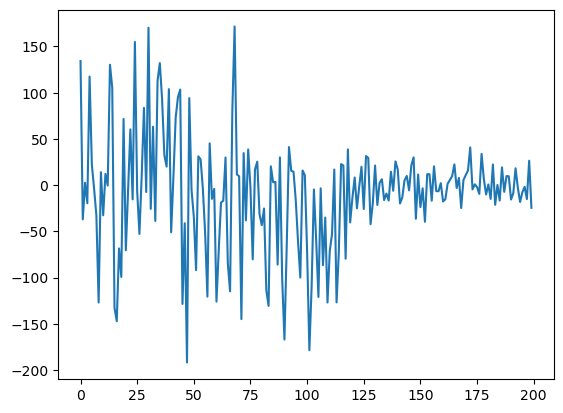

In [7]:
df['Reward'].plot()